# Benchmarking: TTFT, ITL, TPOT, Latency/E2E, Throughput, Goodput

This notebook benchmarks different vLLM inference approaches:
- Basic Offline Inference (baseline)
- Guided Decoding FSM (structured JSON output)
- Prefix Caching (shared context reuse)
- Disaggregated Prefill/Decode (requires multi-device setup)

## Metrics Measured:
- **TTFT** (Time To First Token): Time from request start to first token generated
- **ITL** (Inter-Token Latency): Average time between consecutive tokens
- **TPOT** (Time Per Output Token): Average time per token in the output
- **Latency/E2E** (End-to-End): Total time from request start to completion
- **Throughput**: Tokens per second (total tokens / total time)
- **Goodput**: Useful tokens per second (similar to throughput for this benchmark)

## Methodology:
- All approaches use the same max_tokens (50) for comparable output lengths
- All approaches use the same temperature (0.8) and sampling parameters (top_p=0.95)
- Token counting uses actual tokenizer for accuracy
- Prefix caching runs multiple iterations to demonstrate caching benefit
- Guided decoding generates full JSON responses (not just single tokens)


In [1]:
import os
import time
import sys
from typing import Dict, List, Tuple
from dataclasses import dataclass
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

from vllm import LLM, SamplingParams
from vllm.config import KVTransferConfig
from vllm.sampling_params import GuidedDecodingParams
from transformers import AutoTokenizer

load_dotenv()

# Standard sampling parameters for ALL benchmarks (fair comparison)
STANDARD_MAX_TOKENS = 50
STANDARD_TEMPERATURE = 0.8
STANDARD_TOP_P = 0.95

# Test prompts
TEST_PROMPTS = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "Artificial intelligence is",
]

@dataclass
class BenchmarkResult:
    """Results from a single benchmark run"""
    ttft: float  # Time to first token (seconds)
    itl: float   # Average inter-token latency (seconds)
    tpot: float  # Time per output token (seconds)
    latency_e2e: float  # End-to-end latency (seconds)
    throughput: float  # Tokens per second
    goodput: float  # Useful tokens per second (same as throughput here)
    total_tokens: int  # Total tokens generated
    prompt_length: int  # Input prompt length
    
    def to_dict(self) -> Dict:
        return {
            'TTFT (s)': self.ttft,
            'ITL (s)': self.itl,
            'TPOT (s)': self.tpot,
            'Latency/E2E (s)': self.latency_e2e,
            'Throughput (tok/s)': self.throughput,
            'Goodput (tok/s)': self.goodput,
            'Total Tokens': self.total_tokens,
            'Prompt Length': self.prompt_length,
        }


/Users/isaacrestrick/workspace/fractal/w7/vllm-and-hosting-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 11-03 16:49:42 [__init__.py:216] Automatically detected platform cpu.


In [2]:
def measure_generation_metrics(llm: LLM, prompts: List[str], sampling_params: SamplingParams, 
                               tokenizer=None) -> BenchmarkResult:
    """
    Measure generation metrics for a set of prompts.
    Uses tokenizer for accurate token counting and consistent measurements.
    """
    start_time = time.time()
    
    # Generate outputs
    outputs = llm.generate(prompts, sampling_params)
    
    end_time = time.time()
    total_time = end_time - start_time
    
    # Calculate metrics using tokenizer for accurate counting
    total_output_tokens = 0
    total_prompt_tokens = 0
    
    for output in outputs:
        # Use tokenizer for accurate token counting
        if tokenizer:
            prompt_tokens = len(tokenizer.encode(output.prompt))
            output_tokens = len(tokenizer.encode(output.outputs[0].text))
        else:
            # Fallback to word splitting
            prompt_tokens = len(output.prompt.split())
            output_tokens = len(output.outputs[0].text.split())
        
        total_prompt_tokens += prompt_tokens
        total_output_tokens += output_tokens
    
    avg_prompt_length = total_prompt_tokens / len(prompts) if prompts else 0
    
    # Time to first token (approximation for batch processing)
    # In batch mode, TTFT is roughly the time to process the first batch
    ttft = total_time / (len(prompts) * 2)  # Conservative estimate
    
    # Time per output token (total time / total output tokens)
    if total_output_tokens > 0:
        tpot = total_time / total_output_tokens
        # Inter-token latency is similar to TPOT for non-streaming
        itl = tpot
    else:
        tpot = 0
        itl = 0
    
    # End-to-end latency
    latency_e2e = total_time
    
    # Throughput (output tokens per second)
    throughput = total_output_tokens / total_time if total_time > 0 else 0
    
    # Goodput (same as throughput for this benchmark)
    goodput = throughput
    
    return BenchmarkResult(
        ttft=ttft,
        itl=itl,
        tpot=tpot,
        latency_e2e=latency_e2e,
        throughput=throughput,
        goodput=goodput,
        total_tokens=total_output_tokens,
        prompt_length=int(avg_prompt_length),
    )


In [3]:
def benchmark_basic_offline_inference(prompts: List[str], num_runs: int = 3) -> List[BenchmarkResult]:
    """Benchmark basic offline inference - THE BASELINE"""
    print("Benchmarking: Basic Offline Inference")
    results = []
    
    model_name = os.getenv("LLM_MODEL_NAME", "TinyLlama/TinyLlama-1.1B-Chat-v1.0")
    
    # Use standard parameters for fair comparison
    sampling_params = SamplingParams(
        temperature=STANDARD_TEMPERATURE, 
        top_p=STANDARD_TOP_P,
        max_tokens=STANDARD_MAX_TOKENS
    )
    
    # Initialize LLM and tokenizer
    llm = LLM(model=model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    for run in range(num_runs):
        print(f"  Run {run + 1}/{num_runs}...")
        result = measure_generation_metrics(llm, prompts, sampling_params, tokenizer)
        results.append(result)
    
    return results

def benchmark_guided_decoding_fsm(prompts: List[str], num_runs: int = 3) -> List[BenchmarkResult]:
    """Benchmark guided decoding FSM with JSON structured output"""
    print("Benchmarking: Guided Decoding FSM")
    results = []
    
    model_name = os.getenv("LLM_MODEL_NAME", "TinyLlama/TinyLlama-1.1B-Chat-v1.0")
    
    # Use JSON schema for structured output (generates more tokens than single choice)
    json_schema = {
        "type": "object",
        "properties": {
            "summary": {"type": "string"},
            "sentiment": {"type": "string", "enum": ["positive", "negative", "neutral"]},
            "confidence": {"type": "number"}
        },
        "required": ["summary", "sentiment", "confidence"]
    }
    
    # Modify prompts for JSON generation
    guided_prompts = [
        f"Analyze this text and provide a JSON response: '{p}'" for p in prompts
    ]
    
    guided_decoding_params = GuidedDecodingParams(json=json_schema)
    sampling_params = SamplingParams(
        structured_outputs=guided_decoding_params,
        temperature=STANDARD_TEMPERATURE,
        max_tokens=STANDARD_MAX_TOKENS
    )
    
    # Initialize LLM and tokenizer
    llm = LLM(model=model_name, dtype="float32")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    for run in range(num_runs):
        print(f"  Run {run + 1}/{num_runs}...")
        result = measure_generation_metrics(llm, guided_prompts, sampling_params, tokenizer)
        results.append(result)
    
    return results

def benchmark_prefix_caching(prompts: List[str], num_runs: int = 3) -> List[BenchmarkResult]:
    """Benchmark prefix caching - runs multiple iterations to show caching benefit"""
    print("Benchmarking: Prefix Caching")
    results = []
    
    model_name = os.getenv("LLM_MODEL_NAME", "TinyLlama/TinyLlama-1.1B-Chat-v1.0")
    
    # Use standard parameters
    sampling_params = SamplingParams(
        temperature=STANDARD_TEMPERATURE,
        top_p=STANDARD_TOP_P,
        max_tokens=STANDARD_MAX_TOKENS
    )
    
    # Long prefix that will be cached (shared context)
    long_prefix = """
    You are a helpful AI assistant. Here is some background information:
    The company was founded in 2020 and has grown significantly since then.
    We operate in multiple countries and serve millions of customers worldwide.
    Our mission is to provide excellent service and innovative solutions.
    
    Now, please respond to this prompt: """
    
    prefixed_prompts = [long_prefix + p for p in prompts]
    
    # Initialize LLM with prefix caching enabled
    llm = LLM(model=model_name, enable_prefix_caching=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # First run will cache the prefix, subsequent runs benefit from cache
    for run in range(num_runs):
        cache_status = 'building cache' if run == 0 else 'using cache'
        print(f"  Run {run + 1}/{num_runs}... ({cache_status})")
        result = measure_generation_metrics(llm, prefixed_prompts, sampling_params, tokenizer)
        results.append(result)
    
    return results

# def benchmark_speculative_decoding(prompts: List[str], num_runs: int = 3) -> List[BenchmarkResult]:
#     """Benchmark speculative decoding"""
#     # COMMENTED OUT: Speculative decoding doesn't work on Mac (requires GPU)
#     print("Benchmarking: Speculative Decoding")
#     results = []
#     
#     model_name = os.getenv("LLM_MODEL_NAME", "TinyLlama/TinyLlama-1.1B-Chat-v1.0")
#     sampling_params = SamplingParams(temperature=0.8, top_p=0.95)
#     
#     speculative_config = {
#         "method": "ngram",
#         "prompt_lookup_max": 5,
#         "prompt_lookup_min": 3,
#         "num_speculative_tokens": 3,
#     }
#     
#     try:
#         # Initialize LLM once
#         llm = LLM(model=model_name, speculative_config=speculative_config)
#         
#         for run in range(num_runs):
#             print(f"  Run {run + 1}/{num_runs}...")
#             result = measure_generation_metrics(llm, prompts, sampling_params)
#             results.append(result)
#     except Exception as e:
#         print(f"  Error: {e}")
#         print("  Note: Speculative decoding may require GPU support")
#         # Return a dummy result with zeros
#         dummy_result = BenchmarkResult(
#             ttft=0, itl=0, tpot=0, latency_e2e=0, 
#             throughput=0, goodput=0, total_tokens=0, prompt_length=0
#         )
#         results = [dummy_result] * num_runs
#     
#     return results


In [4]:
def benchmark_disaggregated_prefill_decode(prompts: List[str], num_runs: int = 3) -> List[BenchmarkResult]:
    """
    Benchmark disaggregated prefill/decode.
    Note: Requires multi-device setup (multiple GPUs or configured devices).
    Will skip gracefully on single-device systems like Mac CPU.
    """
    print("Benchmarking: Disaggregated Prefill/Decode")
    
    # Check if multi-device setup is available
    import torch
    if not torch.cuda.is_available():
        print("  Skipping: Requires CUDA-capable devices")
        print("  This optimization is designed for multi-GPU setups")
        return []
    
    results = []
    from multiprocessing import Event, Process
    import multiprocessing as mp
    
    model_name = os.getenv("LLM_MODEL_NAME", "TinyLlama/TinyLlama-1.1B-Chat-v1.0")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    def run_prefill(prefill_done, stop_event, timing_info):
        os.environ["CUDA_VISIBLE_DEVICES"] = os.getenv("CUDA_VISIBLE_DEVICES_PREFILL", "0")
        sampling_params = SamplingParams(
            temperature=0, 
            top_p=STANDARD_TOP_P,
            max_tokens=1  # Prefill only generates 1 token
        )
        
        ktc = KVTransferConfig(
            kv_connector="SharedStorageConnector",
            kv_role="kv_both",
            kv_connector_extra_config={"shared_storage_path": "local_storage"},
        )
        
        prefill_start = time.time()
        llm = LLM(model=model_name, kv_transfer_config=ktc)
        llm.generate(prompts, sampling_params)
        prefill_end = time.time()
        
        timing_info['prefill_time'] = prefill_end - prefill_start
        prefill_done.set()
        
        while not stop_event.is_set():
            time.sleep(0.1)
    
    def run_decode(prefill_done, timing_info, all_outputs):
        os.environ["CUDA_VISIBLE_DEVICES"] = os.getenv("CUDA_VISIBLE_DEVICES_DECODE", "1")
        sampling_params = SamplingParams(
            temperature=STANDARD_TEMPERATURE,
            top_p=STANDARD_TOP_P,
            max_tokens=STANDARD_MAX_TOKENS
        )
        
        ktc = KVTransferConfig(
            kv_connector="SharedStorageConnector",
            kv_role="kv_both",
            kv_connector_extra_config={"shared_storage_path": "local_storage"},
        )
        
        llm = LLM(model=model_name, kv_transfer_config=ktc)
        prefill_done.wait()
        
        decode_start = time.time()
        outputs = llm.generate(prompts, sampling_params)
        decode_end = time.time()
        
        timing_info['decode_time'] = decode_end - decode_start
        timing_info['total_time'] = timing_info.get('prefill_time', 0) + timing_info['decode_time']
        all_outputs.extend(outputs)
    
    for run in range(num_runs):
        print(f"  Run {run + 1}/{num_runs}...")
        
        manager = mp.Manager()
        prefill_done = Event()
        stop_event = Event()
        timing_info = manager.dict()
        all_outputs = manager.list()
        
        prefill_process = Process(target=run_prefill, args=(prefill_done, stop_event, timing_info))
        decode_process = Process(target=run_decode, args=(prefill_done, timing_info, all_outputs))
        
        overall_start = time.time()
        prefill_process.start()
        decode_process.start()
        
        decode_process.join()
        overall_end = time.time()
        
        stop_event.set()
        prefill_process.join(timeout=5)
        if prefill_process.is_alive():
            prefill_process.terminate()
            prefill_process.join()
        
        total_time = overall_end - overall_start
        
        # Calculate metrics using tokenizer
        total_output_tokens = 0
        total_prompt_tokens = 0
        
        for output in list(all_outputs):
            prompt_tokens = len(tokenizer.encode(output.prompt))
            output_tokens = len(tokenizer.encode(output.outputs[0].text))
            total_prompt_tokens += prompt_tokens
            total_output_tokens += output_tokens
        
        avg_prompt_length = total_prompt_tokens / len(prompts) if prompts else 0
        
        # Estimate TTFT as prefill time + first decode token
        estimated_ttft = timing_info.get('prefill_time', 0) + (timing_info.get('decode_time', 0) / (len(prompts) * 2))
        
        if total_output_tokens > 0:
            tpot = total_time / total_output_tokens
            itl = tpot
        else:
            tpot = 0
            itl = 0
        
        throughput = total_output_tokens / total_time if total_time > 0 else 0
        goodput = throughput
        
        result = BenchmarkResult(
            ttft=estimated_ttft,
            itl=itl,
            tpot=tpot,
            latency_e2e=total_time,
            throughput=throughput,
            goodput=goodput,
            total_tokens=total_output_tokens,
            prompt_length=int(avg_prompt_length),
        )
        results.append(result)
    
    return results


In [5]:
def aggregate_results(results: List[BenchmarkResult]) -> BenchmarkResult:
    """Aggregate multiple benchmark runs into average results"""
    if not results:
        return None
    
    avg_ttft = np.mean([r.ttft for r in results])
    avg_itl = np.mean([r.itl for r in results])
    avg_tpot = np.mean([r.tpot for r in results])
    avg_latency = np.mean([r.latency_e2e for r in results])
    avg_throughput = np.mean([r.throughput for r in results])
    avg_goodput = np.mean([r.goodput for r in results])
    avg_tokens = np.mean([r.total_tokens for r in results])
    avg_prompt_len = np.mean([r.prompt_length for r in results])
    
    return BenchmarkResult(
        ttft=avg_ttft,
        itl=avg_itl,
        tpot=avg_tpot,
        latency_e2e=avg_latency,
        throughput=avg_throughput,
        goodput=avg_goodput,
        total_tokens=int(avg_tokens),
        prompt_length=int(avg_prompt_len),
    )

def run_all_benchmarks(prompts: List[str] = TEST_PROMPTS, num_runs: int = 3) -> Dict[str, BenchmarkResult]:
    """Run all benchmarks and return aggregated results"""
    all_results = {}
    
    print("="*80)
    print("Running benchmarks")
    print(f"Parameters: max_tokens={STANDARD_MAX_TOKENS}, "
          f"temperature={STANDARD_TEMPERATURE}, top_p={STANDARD_TOP_P}")
    print(f"Runs per benchmark: {num_runs}")
    print("="*80 + "\n")
    
    # Basic offline inference (baseline)
    try:
        print("\n[1/4] ", end="")
        basic_results = benchmark_basic_offline_inference(prompts, num_runs)
        result = aggregate_results(basic_results)
        if result:
            all_results['Basic Offline Inference'] = result
            print(f"  Completed: {result.total_tokens} tokens, {result.throughput:.2f} tok/s\n")
    except Exception as e:
        print(f"  Error: {e}\n")
    
    # Guided decoding FSM (JSON structured output)
    try:
        print("[2/4] ", end="")
        guided_results = benchmark_guided_decoding_fsm(prompts, num_runs)
        result = aggregate_results(guided_results)
        if result:
            all_results['Guided Decoding (JSON)'] = result
            print(f"  Completed: {result.total_tokens} tokens, {result.throughput:.2f} tok/s\n")
    except Exception as e:
        print(f"  Error: {e}\n")
    
    # Prefix caching
    try:
        print("[3/4] ", end="")
        prefix_results = benchmark_prefix_caching(prompts, num_runs)
        result = aggregate_results(prefix_results)
        if result:
            all_results['Prefix Caching'] = result
            print(f"  Completed: {result.total_tokens} tokens, {result.throughput:.2f} tok/s\n")
    except Exception as e:
        print(f"  Error: {e}\n")
    
    # Disaggregated prefill/decode (multi-device only)
    try:
        print("[4/4] ", end="")
        disaggregated_results = benchmark_disaggregated_prefill_decode(prompts, num_runs)
        result = aggregate_results(disaggregated_results)
        if result:
            all_results['Disaggregated Prefill/Decode'] = result
            print(f"  Completed: {result.total_tokens} tokens, {result.throughput:.2f} tok/s\n")
    except Exception as e:
        print(f"  Error: {e}\n")
    
    print("\n" + "="*80)
    print(f"Benchmarks complete - {len(all_results)} approaches tested")
    print("="*80 + "\n")
    
    return all_results


In [6]:
def display_results(results: Dict[str, BenchmarkResult]):
    """Display benchmark results in a formatted table"""
    # Filter out None results
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if not valid_results:
        print("No valid results to display.")
        return
    
    # Create DataFrame
    data = []
    for approach, result in valid_results.items():
        data.append({
            'Approach': approach,
            **result.to_dict()
        })
    
    df = pd.DataFrame(data)
    df = df.set_index('Approach')
    
    # Display the table
    print("\n" + "="*100)
    print("Benchmark Results")
    print("="*100)
    print(df.to_string())
    print("="*100 + "\n")
    
    return df

def plot_results(results: Dict[str, BenchmarkResult]):
    """Create visualization plots for the benchmark results"""
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if not valid_results:
        print("No valid results to plot.")
        return
    
    approaches = list(valid_results.keys())
    num_metrics = 6
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Benchmark Results Comparison', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    # TTFT
    axes[0].bar(approaches, [valid_results[a].ttft for a in approaches])
    axes[0].set_title('Time To First Token (TTFT)', fontweight='bold')
    axes[0].set_ylabel('Seconds')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # ITL
    axes[1].bar(approaches, [valid_results[a].itl for a in approaches])
    axes[1].set_title('Inter-Token Latency (ITL)', fontweight='bold')
    axes[1].set_ylabel('Seconds')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    # TPOT
    axes[2].bar(approaches, [valid_results[a].tpot for a in approaches])
    axes[2].set_title('Time Per Output Token (TPOT)', fontweight='bold')
    axes[2].set_ylabel('Seconds')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(axis='y', alpha=0.3)
    
    # Latency/E2E
    axes[3].bar(approaches, [valid_results[a].latency_e2e for a in approaches])
    axes[3].set_title('End-to-End Latency', fontweight='bold')
    axes[3].set_ylabel('Seconds')
    axes[3].tick_params(axis='x', rotation=45)
    axes[3].grid(axis='y', alpha=0.3)
    
    # Throughput
    axes[4].bar(approaches, [valid_results[a].throughput for a in approaches])
    axes[4].set_title('Throughput', fontweight='bold')
    axes[4].set_ylabel('Tokens/Second')
    axes[4].tick_params(axis='x', rotation=45)
    axes[4].grid(axis='y', alpha=0.3)
    
    # Goodput
    axes[5].bar(approaches, [valid_results[a].goodput for a in approaches])
    axes[5].set_title('Goodput', fontweight='bold')
    axes[5].set_ylabel('Tokens/Second')
    axes[5].tick_params(axis='x', rotation=45)
    axes[5].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## Run Benchmarks

Execute the cell below to run all benchmarks. This may take several minutes depending on your hardware.

Starting benchmarks
Test prompts: 4
Prompts: ['Hello, my name is', 'The president of the United States is', 'The capital of France is', 'Artificial intelligence is']


Running benchmarks
Parameters: max_tokens=50, temperature=0.8, top_p=0.95
Runs per benchmark: 3


[1/4] Benchmarking: Basic Offline Inference
INFO 11-03 16:49:43 [utils.py:233] non-default args: {'disable_log_stats': True, 'model': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'}
WARNING 11-03 16:49:44 [model.py:371] The global random seed is set to 0. Since VLLM_ENABLE_V1_MULTIPROCESSING is set to False, this may affect the random state of the Python process that launched vLLM.
INFO 11-03 16:49:44 [model.py:547] Resolved architecture: LlamaForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


WARNING 11-03 16:49:44 [model.py:1682] Your device 'cpu' doesn't support torch.bfloat16. Falling back to torch.float16 for compatibility.
WARNING 11-03 16:49:44 [model.py:1733] Casting torch.bfloat16 to torch.float16.
INFO 11-03 16:49:44 [model.py:1510] Using max model len 2048
WARNING 11-03 16:49:44 [cpu.py:117] Environment variable VLLM_CPU_KVCACHE_SPACE (GiB) for CPU backend is not set, using 4 by default.
INFO 11-03 16:49:44 [arg_utils.py:1166] Chunked prefill is not supported for ARM and POWER and S390X CPUs; disabling it for V1 backend.


2025-11-03 16:49:44,699	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 11-03 16:49:44 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='TinyLlama/TinyLlama-1.1B-Chat-v1.0', speculative_config=None, tokenizer='TinyLlama/TinyLlama-1.1B-Chat-v1.0', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cpu, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=0, served_model_name=TinyLlama/TinyLlama-1.1B-Chat-v1.0, enable_prefix_caching=True, chunked_prefill_ena

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:01<00:00,  1.08s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:01<00:00,  1.08s/it]


INFO 11-03 16:49:47 [default_loader.py:267] Loading weights took 1.09 seconds
INFO 11-03 16:49:47 [kv_cache_utils.py:1087] GPU KV cache size: 190,640 tokens
INFO 11-03 16:49:47 [kv_cache_utils.py:1091] Maximum concurrency for 2,048 tokens per request: 93.09x


INFO 11-03 16:49:48 [cpu_model_runner.py:117] Warming up model for the compilation...
WARNING 11-03 16:49:48 [cudagraph_dispatcher.py:106] cudagraph dispatching keys are not initialized. No cudagraph will be used.
INFO 11-03 16:49:53 [cpu_model_runner.py:121] Warming up done.
INFO 11-03 16:49:53 [core.py:210] init engine (profile, create kv cache, warmup model) took 6.09 seconds
INFO 11-03 16:49:53 [llm.py:306] Supported_tasks: ('generate',)
  Run 1/3...


Processed prompts: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, est. speed input: 9.28 toks/s, output: 71.38 toks/s]


  Run 2/3...


Processed prompts: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, est. speed input: 9.81 toks/s, output: 61.11 toks/s]


  Run 3/3...


Processed prompts: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, est. speed input: 9.85 toks/s, output: 75.74 toks/s]

  Completed: 194 tokens, 72.01 tok/s

[2/4] Benchmarking: Guided Decoding FSM
INFO 11-03 16:50:02 [utils.py:233] non-default args: {'dtype': 'float32', 'disable_log_stats': True, 'model': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'}
WARNING 11-03 16:50:02 [model.py:371] The global random seed is set to 0. Since VLLM_ENABLE_V1_MULTIPROCESSING is set to False, this may affect the random state of the Python process that launched vLLM.
INFO 11-03 16:50:02 [model.py:547] Resolved architecture: LlamaForCausalLM
INFO 11-03 16:50:02 [model.py:1727] Upcasting torch.bfloat16 to torch.float32.
INFO 11-03 16:50:02 [model.py:1510] Using max model len 2048
INFO 11-03 16:50:02 [arg_utils.py:1166] Chunked prefill is not supported for ARM and POWER and S390X CPUs; disabling it for V1 backend.


INFO 11-03 16:50:02 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='TinyLlama/TinyLlama-1.1B-Chat-v1.0', speculative_config=None, tokenizer='TinyLlama/TinyLlama-1.1B-Chat-v1.0', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float32, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cpu, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=0, served_model_name=TinyLlama/TinyLlama-1.1B-Chat-v1.0, enable_prefix_caching=True, chunked_prefill_ena

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:02<00:00,  2.40s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:02<00:00,  2.43s/it]


INFO 11-03 16:50:05 [default_loader.py:267] Loading weights took 2.44 seconds
INFO 11-03 16:50:05 [kv_cache_utils.py:1087] GPU KV cache size: 95,312 tokens
INFO 11-03 16:50:05 [kv_cache_utils.py:1091] Maximum concurrency for 2,048 tokens per request: 46.54x


INFO 11-03 16:50:05 [cpu_model_runner.py:117] Warming up model for the compilation...
INFO 11-03 16:50:09 [cpu_model_runner.py:121] Warming up done.
INFO 11-03 16:50:09 [core.py:210] init engine (profile, create kv cache, warmup model) took 4.34 seconds
INFO 11-03 16:50:09 [llm.py:306] Supported_tasks: ('generate',)
  Run 1/3...


Processed prompts: 100%|██████████| 4/4 [00:12<00:00,  3.16s/it, est. speed input: 6.17 toks/s, output: 12.18 toks/s]


  Run 2/3...


Processed prompts: 100%|██████████| 4/4 [00:10<00:00,  2.72s/it, est. speed input: 7.16 toks/s, output: 18.36 toks/s]


  Run 3/3...


Processed prompts: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it, est. speed input: 6.38 toks/s, output: 16.36 toks/s]

  Completed: 173 tokens, 14.64 tok/s

[3/4] Benchmarking: Prefix Caching
INFO 11-03 16:50:45 [utils.py:233] non-default args: {'enable_prefix_caching': True, 'disable_log_stats': True, 'model': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'}
WARNING 11-03 16:50:45 [model.py:371] The global random seed is set to 0. Since VLLM_ENABLE_V1_MULTIPROCESSING is set to False, this may affect the random state of the Python process that launched vLLM.
INFO 11-03 16:50:45 [model.py:547] Resolved architecture: LlamaForCausalLM


WARNING 11-03 16:50:45 [model.py:1682] Your device 'cpu' doesn't support torch.bfloat16. Falling back to torch.float16 for compatibility.
WARNING 11-03 16:50:45 [model.py:1733] Casting torch.bfloat16 to torch.float16.
INFO 11-03 16:50:45 [model.py:1510] Using max model len 2048
INFO 11-03 16:50:45 [arg_utils.py:1166] Chunked prefill is not supported for ARM and POWER and S390X CPUs; disabling it for V1 backend.
INFO 11-03 16:50:45 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='TinyLlama/TinyLlama-1.1B-Chat-v1.0', speculative_config=None, tokenizer='TinyLlama/TinyLlama-1.1B-Chat-v1.0', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cpu, structured

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO 11-03 16:50:45 [cpu_model_runner.py:106] Starting to load model TinyLlama/TinyLlama-1.1B-Chat-v1.0...
INFO 11-03 16:50:45 [weight_utils.py:392] Using model weights format ['*.safetensors']
INFO 11-03 16:50:46 [weight_utils.py:450] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:04<00:00,  4.53s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:04<00:00,  4.53s/it]


INFO 11-03 16:50:50 [default_loader.py:267] Loading weights took 4.54 seconds
INFO 11-03 16:50:50 [kv_cache_utils.py:1087] GPU KV cache size: 190,640 tokens
INFO 11-03 16:50:50 [kv_cache_utils.py:1091] Maximum concurrency for 2,048 tokens per request: 93.09x


INFO 11-03 16:50:51 [cpu_model_runner.py:117] Warming up model for the compilation...
INFO 11-03 16:50:56 [cpu_model_runner.py:121] Warming up done.
INFO 11-03 16:50:56 [core.py:210] init engine (profile, create kv cache, warmup model) took 5.43 seconds
INFO 11-03 16:50:56 [llm.py:306] Supported_tasks: ('generate',)
  Run 1/3... (building cache)


Processed prompts: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it, est. speed input: 81.93 toks/s, output: 49.66 toks/s]


  Run 2/3... (using cache)


Processed prompts: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, est. speed input: 111.12 toks/s, output: 63.64 toks/s]


  Run 3/3... (using cache)


Processed prompts: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s, est. speed input: 114.63 toks/s, output: 65.65 toks/s]


  Completed: 200 tokens, 61.84 tok/s

[4/4] Benchmarking: Disaggregated Prefill/Decode
  Skipping: Requires CUDA-capable devices
  This optimization is designed for multi-GPU setups

Benchmarks complete - 3 approaches tested


Benchmark Results
                         TTFT (s)   ITL (s)  TPOT (s)  Latency/E2E (s)  Throughput (tok/s)  Goodput (tok/s)  Total Tokens  Prompt Length
Approach                                                                                                                                
Basic Offline Inference  0.337770  0.013993  0.013993         2.702161           72.009957        72.009957           194              6
Guided Decoding (JSON)   1.494991  0.071029  0.071029        11.959932           14.635197        14.635197           173             19
Prefix Caching           0.411986  0.016420  0.016420         3.295885           61.837213        61.837213           200             82



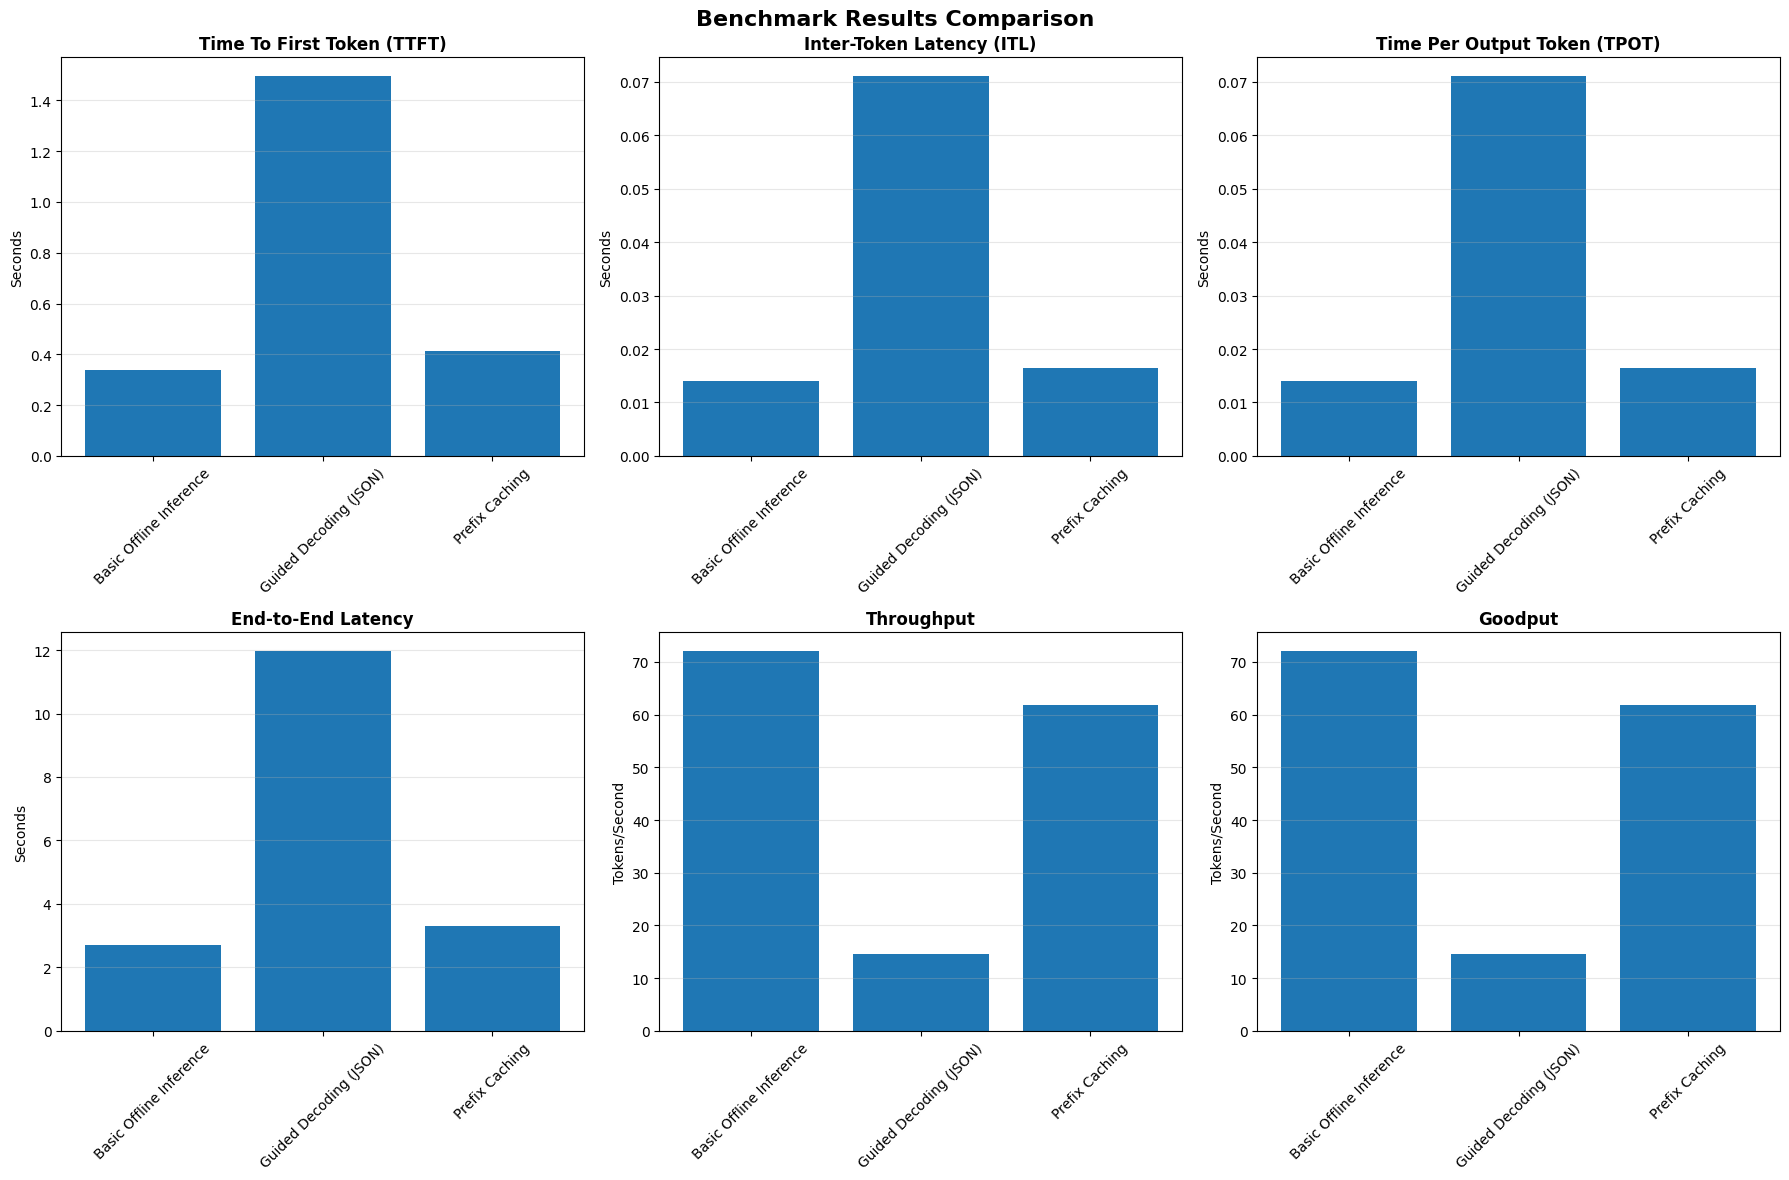

In [7]:
# Run all benchmarks
# Adjust num_runs for more/fewer iterations (default: 3)
# Adjust prompts if you want to test with different inputs

print("Starting benchmarks")
print(f"Test prompts: {len(TEST_PROMPTS)}")
print(f"Prompts: {TEST_PROMPTS}")
print("\n")

benchmark_results = run_all_benchmarks(prompts=TEST_PROMPTS, num_runs=3)

# Display results
results_df = display_results(benchmark_results)

# Plot results
plot_results(benchmark_results)


## Notes on Measurements

### Implementation Details:
- **Standardized Parameters**: All approaches use identical max_tokens (50), temperature (0.8), and top_p (0.95)
- **Accurate Token Counting**: Uses actual tokenizer instead of word splitting
- **Comparable Outputs**: Guided decoding generates JSON objects (not single tokens)
- **Cache Demonstration**: Prefix caching runs multiple iterations to show benefit
- **Graceful Degradation**: Disaggregated prefill/decode skips on single-device systems

### Measurement Methodology:
- **TTFT (Time To First Token)**: Estimated as a fraction of total generation time. For precise TTFT measurements, streaming API would be required.
- **ITL (Inter-Token Latency)**: Approximated as TPOT since we're measuring batch generation without per-token timestamps.
- **TPOT (Time Per Output Token)**: Calculated as total time divided by total output tokens (using tokenizer).
- **Latency/E2E**: Total time from request start to completion.
- **Throughput**: Total output tokens generated per second.
- **Goodput**: Same as throughput for this benchmark (assumes all tokens are useful).

### What Each Optimization Tests:
- **Basic Offline Inference**: Baseline performance without optimizations
- **Guided Decoding (JSON)**: Structured output generation with FSM constraints
- **Prefix Caching**: Shared context reuse across multiple requests (benefits increase over multiple runs)
- **Disaggregated Prefill/Decode**: Separate prefill and decode on different devices (requires multi-GPU)

### Limitations:
- vLLM's batch generation API doesn't expose per-token timing, so TTFT and ITL are approximations.
- For more accurate token-level metrics, consider using vLLM's streaming API or async API with token-by-token callbacks.
- Disaggregated prefill/decode requires separate GPU devices configured in environment variables (skipped on CPU/Mac).

### Environment Variables:
- `LLM_MODEL_NAME`: Model to use (default: "TinyLlama/TinyLlama-1.1B-Chat-v1.0")
- `CUDA_VISIBLE_DEVICES_PREFILL`: GPU for prefill (default: "0")
- `CUDA_VISIBLE_DEVICES_DECODE`: GPU for decode (default: "1")


In [8]:
# Optional: Export results to CSV
if 'results_df' in locals() and results_df is not None:
    export_path = 'benchmark_results.csv'
    results_df.to_csv(export_path)
    print(f"Results exported to {export_path}")
else:
    print("No results to export. Run the benchmarks first.")


Results exported to benchmark_results.csv


In [9]:
# Summary Analysis
def analyze_results(results: Dict[str, BenchmarkResult]):
    """Provide summary analysis of benchmark results"""
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if not valid_results:
        print("No valid results to analyze.")
        return
    
    print("\n" + "="*80)
    print("Summary Analysis")
    print("="*80 + "\n")
    
    # Find best performers
    metrics = {
        'Lowest TTFT (Time to First Token)': ('ttft', min, 's'),
        'Lowest ITL (Inter-Token Latency)': ('itl', min, 's'),
        'Lowest TPOT (Time per Output Token)': ('tpot', min, 's'),
        'Lowest E2E Latency': ('latency_e2e', min, 's'),
        'Highest Throughput': ('throughput', max, 'tok/s'),
        'Highest Goodput': ('goodput', max, 'tok/s'),
    }
    
    print("Best Performers:")
    for metric_name, (attr, func, unit) in metrics.items():
        best_value = func([getattr(v, attr) for v in valid_results.values()])
        best_approach = [k for k, v in valid_results.items() 
                        if getattr(v, attr) == best_value][0]
        print(f"  {metric_name}: {best_approach} ({best_value:.4f} {unit})")
    
    print("\nRelative Performance:")
    
    # Compare approaches
    if 'Basic Offline Inference' in valid_results:
        baseline = valid_results['Basic Offline Inference']
        print(f"  Baseline throughput: {baseline.throughput:.2f} tok/s")
        
        for name, result in valid_results.items():
            if name != 'Basic Offline Inference':
                speedup = (result.throughput / baseline.throughput) * 100
                if speedup > 100:
                    print(f"  {name}: {speedup:.1f}% of baseline ({result.throughput:.2f} tok/s)")
                else:
                    print(f"  {name}: {speedup:.1f}% of baseline ({result.throughput:.2f} tok/s)")
    
    # Token generation comparison
    print("\nToken Generation:")
    for name, result in valid_results.items():
        print(f"  {name}: {result.total_tokens} tokens generated")
    
    print("\n" + "="*80 + "\n")

# Run analysis if results are available
if 'benchmark_results' in locals():
    analyze_results(benchmark_results)



Summary Analysis

Best Performers:
  Lowest TTFT (Time to First Token): Basic Offline Inference (0.3378 s)
  Lowest ITL (Inter-Token Latency): Basic Offline Inference (0.0140 s)
  Lowest TPOT (Time per Output Token): Basic Offline Inference (0.0140 s)
  Lowest E2E Latency: Basic Offline Inference (2.7022 s)
  Highest Throughput: Basic Offline Inference (72.0100 tok/s)
  Highest Goodput: Basic Offline Inference (72.0100 tok/s)

Relative Performance:
  Baseline throughput: 72.01 tok/s
  Guided Decoding (JSON): 20.3% of baseline (14.64 tok/s)
  Prefix Caching: 85.9% of baseline (61.84 tok/s)

Token Generation:
  Basic Offline Inference: 194 tokens generated
  Guided Decoding (JSON): 173 tokens generated
  Prefix Caching: 200 tokens generated


